#### Set up
Run this section before anything else

In [1]:
from datetime import datetime, timedelta
import Dataloader_ricequant as dl

import pandas as pd
import rqdatac as rq
import missingno as msno
from constants import *
import scipy
import statsmodels as sm
import seaborn as sns
import numpy as np
import pathos
from tqdm.notebook import tqdm
import multiprocessing
import pickle

In [2]:
def applyParallel(dfGrouped, func):
    #parrallel computing version of pd.groupby.apply, works most of the time but not always
    #I mainly use it for cases where func takes in a dataframe and outputs a dataframe or a series
    with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool:
        ret_list = pool.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [3]:
dl.rq_initialize()

/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/rqdatac/client.py:238: UserWarning: Your account will be expired after  149 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  "renew your contract.".format(remaining_days))


In [4]:
def sort_index_and_col(df) -> pd.DataFrame:
    #sort the dataframe by index and column
    return df.sort_index(axis=0).reindex(sorted(df.columns), axis=1)
    #the following might achieve the same result in a cleaner way
    # return df.sort_index(axis=0).sort_index(axis=1)

In [5]:
results = dl.load_basic_info()

## Load Industry Data

In [6]:
df_indus_mapping = dl.load_industry_mapping()

## TBD: Load Index Data
### In hiearachical backtesting we need weights of index(沪深300，中证500 etc.) data to make the portfolio to stay industry-neutral with the index
### Currently index data is assumed to be uniformly weighted among all stocks

In [7]:
# index_weights_by_date = []
# for date in tqdm(pd.date_range(START_DATE, END_DATE, freq='B')):
#     index_weights = rq.index_weights('000016.XSHG', date)
#     index_weights_by_date.append(index_weights)

#### Data Preprocessing

Major Steps: 

0) Read all csv's and concatenate the desired column from each dataframe
1) Filter data between START_DATE and END_DATE(backtesting period). 
2) Filter listed stocks
3) Filter non-ST, not suspended and listed stocks


In [8]:
df_backtest = pd.concat(results, axis=0).rename(columns={'code': 'stock'}).loc[:, INDEX_COLS + BASIC_INFO_COLS]
df_backtest['date'] = pd.to_datetime(df_backtest['date'])
df_backtest = df_backtest[ (START_DATE <= df_backtest['date']) & (df_backtest['date'] <= END_DATE) ]
df_backtest['stock'] = df_backtest['stock'].apply(lambda stock: dl.normalize_code(stock))
df_backtest = df_backtest.set_index(INDEX_COLS).sort_index()
df_backtest = df_backtest.unstack(level=1).stack(dropna=False)

In [9]:
stock_names = df_backtest.index.get_level_values(1).unique()
stock_names

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '688668.XSHG', '688678.XSHG', '688679.XSHG', '688686.XSHG',
       '688698.XSHG', '688699.XSHG', '688777.XSHG', '688788.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='stock', length=4196)

In [10]:
stock_names

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '688668.XSHG', '688678.XSHG', '688679.XSHG', '688686.XSHG',
       '688698.XSHG', '688699.XSHG', '688777.XSHG', '688788.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='stock', length=4196)

In [11]:
# with open('./Data/raw_data/stock_names.h5', 'wb') as fp:
#     pickle.dump(stock_names, fp)

In [12]:
with open('./Data/raw_data/stock_names.h5', 'rb') as fp:
     stock_names = pickle.load(fp)

In [13]:
df_backtest

PE_TTM     PS_TTM      PC_TTM         PB  \
date       stock                                                      
2011-01-04 000001.XSHE   8.865369   3.275312    1.187931   1.736868   
           000002.XSHE  17.143047   2.319354  -30.282091   2.403611   
           000004.XSHE  72.239436   8.031760   71.600273  14.373444   
           000005.XSHE -53.807405  79.472714  165.599447   5.077750   
           000006.XSHE  15.341738   1.899546  269.949866   2.643284   
...                           ...        ...         ...        ...   
2020-12-31 688699.XSHG        NaN        NaN         NaN        NaN   
           688777.XSHG        NaN        NaN         NaN        NaN   
           688788.XSHG        NaN        NaN         NaN        NaN   
           688981.XSHG        NaN        NaN         NaN        NaN   
           689009.XSHG        NaN        NaN         NaN        NaN   

                        market_value    open   close  
date       stock                                      
2011-01-04 000001.XSHE  5.582992e+10   15.82   16.02  
           000002.XSHE  8.518624e+10    8.27    8.80  
           000004.XSHE  1.015278e+09   12.14   12.09  
           000005.XSHE  3.428751e+09    3.68    3.75  
           000006.XSHE  5.530833e+09    7.05    7.27  
...                              ...     ...     ...  
2020-12-31 688699.XSHG  4.103000e+09   54.00   55.17  
           688777.XSHG  4.922700e+10   99.58  100.20  
           688788.XSHG  1.006900e+10  134.49  133.30  
           688981.XSHG  4.448770e+11   57.00   57.75  
           689009.XSHG  6.042500e+10   82.00   85.82  

[10204672 rows x 7 columns]

In [14]:
df_is_st = dl.load_st_data(stock_names)
df_is_suspended = dl.load_suspended_data(stock_names)

In [15]:
df_is_st

2011-01-04  000001.XSHE    False
            000002.XSHE    False
            000004.XSHE     True
            000005.XSHE    False
            000006.XSHE    False
                           ...  
2020-12-31  688699.XSHG    False
            688777.XSHG    False
            688788.XSHG    False
            688981.XSHG    False
            689009.XSHG    False
Length: 10204672, dtype: bool

In [16]:
#get the listed date column
listed_dates = {dl.normalize_code(result['code'][0]): result['date'].min() for result in results}
listed_dates = pd.DataFrame(pd.Series(listed_dates), columns=['listed_date']).sort_index()
df_backtest = df_backtest.merge(listed_dates, left_on = 'stock', right_index=True, how='left')
df_backtest['is_listed'] = (df_backtest.index.get_level_values(level=0) >= df_backtest['listed_date'])

In [17]:
stock_names

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '688668.XSHG', '688678.XSHG', '688679.XSHG', '688686.XSHG',
       '688698.XSHG', '688699.XSHG', '688777.XSHG', '688788.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='stock', length=4196)

In [18]:
df_is_st

2011-01-04  000001.XSHE    False
            000002.XSHE    False
            000004.XSHE     True
            000005.XSHE    False
            000006.XSHE    False
                           ...  
2020-12-31  688699.XSHG    False
            688777.XSHG    False
            688788.XSHG    False
            688981.XSHG    False
            689009.XSHG    False
Length: 10204672, dtype: bool

In [19]:
df_is_suspended

2011-01-04  000001.XSHE    False
            000002.XSHE    False
            000004.XSHE    False
            000005.XSHE    False
            000006.XSHE    False
                           ...  
2020-12-31  688699.XSHG    False
            688777.XSHG    False
            688788.XSHG    False
            688981.XSHG    False
            689009.XSHG    False
Length: 10204672, dtype: bool

In [20]:
#get ST and suspended column
df_backtest['is_st'] = df_is_st.values
df_backtest['is_suspended'] = df_is_suspended.values
#filter out ST and suspended stocks, filter data by the stock's listed date
df_backtest = df_backtest.loc[ (~df_backtest['is_st']) & (~df_backtest['is_suspended']) & (df_backtest['is_listed']), BASIC_INFO_COLS]
#keep data only on the rebalancing dates
rebalancing_dates = pd.date_range(start=START_DATE, end=END_DATE, freq='BM')
df_backtest = df_backtest[df_backtest.index.get_level_values(0).isin(rebalancing_dates)]

In [21]:
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-12-31 688699.XSHG        NaN        NaN         NaN       NaN   
           688777.XSHG        NaN        NaN         NaN       NaN   
           688788.XSHG        NaN        NaN         NaN       NaN   
           688981.XSHG        NaN        NaN         NaN       NaN   
           689009.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  
date       stock                                      
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31  
           000002.XSHE  7.937809e+10    8.25    8.20  
           000005.XSHE  3.200168e+09    3.46    3.50  
           000006.XSHE  5.409109e+09    7.15    7.11  
           000009.XSHE  1.937173e+10   17.05   17.76  
...                              ...     ...     ...  
2020-12-31 688699.XSHG  4.103000e+09   54.00   55.17  
           688777.XSHG  4.922700e+10   99.58  100.20  
           688788.XSHG  1.006900e+10  134.49  133.30  
           688981.XSHG  4.448770e+11   57.00   57.75  
           689009.XSHG  6.042500e+10   82.00   85.82  

[309779 rows x 7 columns]

In [22]:
#the current rebalancing date is the last trading day of the current period
#'next_period_open' is defined as the stock's open price on the next relancing date
#'next_period_return' is the generated return by holding a stock from EOD of current rebalancing date to the start of the next rebalancing date
df_backtest['next_period_open'] = df_backtest['open'].groupby(level=1).shift(-1).values
df_backtest['next_period_return'] = (df_backtest['next_period_open'].values - df_backtest['close'].values) / df_backtest['close'].values
df_backtest = df_backtest[df_backtest.index.get_level_values(0) != df_backtest.index.get_level_values(0).max()]

In [23]:
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688600.XSHG        NaN        NaN         NaN       NaN   
           688777.XSHG        NaN        NaN         NaN       NaN   
           688788.XSHG        NaN        NaN         NaN       NaN   
           688981.XSHG        NaN        NaN         NaN       NaN   
           689009.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688600.XSHG  2.733000e+09   20.49   20.50             16.86   
           688777.XSHG  6.092000e+10  122.00  124.00             99.58   
           688788.XSHG  1.728500e+10  223.00  228.84            134.49   
           688981.XSHG  4.562330e+11   58.88   59.25             57.00   
           689009.XSHG  5.023700e+10   72.60   71.35             82.00   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688600.XSHG           -0.177561  
           688777.XSHG           -0.196935  
           688788.XSHG           -0.412297  
           688981.XSHG           -0.037975  
           689009.XSHG            0.149264  

[305805 rows x 9 columns]

## Data Preprocessing part 2
### 1) Remove Outliers
### 2) Standardization - Subtract mean and divide by std
### 3) Fill missing values with 0


In [24]:
def remove_outlier(df, n=3):
    #for any factor, if the stock's factor exposure lies more than n times MAD away from the factor's median, 
    # reset that stock's factor exposure to median + n * MAD/median - n* MAD
    med = df.median(axis=0)
    MAD = (df - med).abs().median()
    upper_limit = med + n * MAD
    lower_limit = med - n * MAD
    print(f"lower_limit = {lower_limit}, upper_limit = {upper_limit}")
    #pd.DataFrame.where replaces data in the dataframe by 'other' where the condition is False 
    df = df.where(df <= upper_limit, other = upper_limit, axis=1)
    df = df.where(df >= lower_limit, other = lower_limit, axis=1)
    return df

In [25]:
df_backtest.groupby(level=0)[TEST_FACTORS].agg('sum')

,PE_TTM,PS_TTM,PC_TTM,PB
date,,,,
2011-01-31,62284.978367,8294.520947,30147.223650,8833.169464
2011-02-28,71634.246989,8711.615164,25835.173731,9399.392288
2011-03-31,159596.791786,9504.488037,36762.898708,9426.752556
2011-04-29,132727.256506,10209.401039,-18775.133366,8736.007973
2011-05-31,119891.629847,9532.234645,59957.219910,8148.175216
...,...,...,...,...
2020-07-31,313101.734018,17765.949923,84815.728149,14948.160701
2020-08-31,321013.730282,17935.516171,84444.773349,15227.465986
2020-09-30,276967.073128,16305.244345,71375.799088,14045.338750


In [26]:
df_backtest[TEST_FACTORS] = applyParallel(df_backtest[TEST_FACTORS].groupby(level=0), remove_outlier).values

lower_limit = PE_TTM   -15.255889
PS_TTM    -2.599590
PC_TTM   -64.942341
PB         0.196030
dtype: float64, upper_limit = PE_TTM    107.757791
PS_TTM      9.564759
PC_TTM    111.787020
PB          8.309510
dtype: float64lower_limit = PE_TTM   -19.915215
PS_TTM    -2.294267
PC_TTM   -54.024687
PB         0.011643
dtype: float64, upper_limit = PE_TTM    104.299748
PS_TTM      8.470381
PC_TTM     96.117973
PB          8.298675
dtype: float64lower_limit = PE_TTM   -11.923082
PS_TTM    -2.353394
PC_TTM   -63.965851
PB         0.148056
dtype: float64, upper_limit = PE_TTM     88.419124
PS_TTM      8.509594
PC_TTM    104.321705
PB          6.646734
dtype: float64lower_limit = PE_TTM    -8.862852
PS_TTM    -1.988819
PC_TTM   -57.783937
PB         0.180819
dtype: float64, upper_limit = PE_TTM    69.193206
PS_TTM     7.003081
PC_TTM    87.324551
PB         5.793327
dtype: float64lower_limit = PE_TTM   -10.694603
PS_TTM    -2.014302
PC_TTM   -63.636377
PB         0.125878
dtype: float64, upper_

/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [27]:
df_backtest

PE_TTM    PS_TTM     PC_TTM        PB  \
date       stock                                                   
2011-01-31 000001.XSHE   8.472443  3.130145   1.135280  1.659888   
           000002.XSHE  15.974212  2.161218 -28.217419  2.239730   
           000005.XSHE -19.915215  8.470381  96.117973  4.739232   
           000006.XSHE  15.004099  1.857741  96.117973  2.585111   
           000009.XSHE  61.799492  6.153490 -26.665920  8.004300   
...                           ...       ...        ...       ...   
2020-11-30 688600.XSHG  88.238709  7.906307  92.043555  6.427784   
           688777.XSHG  88.238709  7.906307  92.043555  6.427784   
           688788.XSHG  88.238709  7.906307  92.043555  6.427784   
           688981.XSHG  88.238709  7.906307  92.043555  6.427784   
           689009.XSHG  88.238709  7.906307  92.043555  6.427784   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688600.XSHG  2.733000e+09   20.49   20.50             16.86   
           688777.XSHG  6.092000e+10  122.00  124.00             99.58   
           688788.XSHG  1.728500e+10  223.00  228.84            134.49   
           688981.XSHG  4.562330e+11   58.88   59.25             57.00   
           689009.XSHG  5.023700e+10   72.60   71.35             82.00   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688600.XSHG           -0.177561  
           688777.XSHG           -0.196935  
           688788.XSHG           -0.412297  
           688981.XSHG           -0.037975  
           689009.XSHG            0.149264  

[305805 rows x 9 columns]

In [28]:
def standardize(df):
    #on each rebalancing date, each standardized factor has mean 0 and std 1
    return (df - df.mean()) / df.std()

df_backtest[TEST_FACTORS] = applyParallel(df_backtest[TEST_FACTORS].groupby(level=0), standardize).values

/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [29]:
df_backtest[TEST_FACTORS] = df_backtest[TEST_FACTORS].fillna(0).values

/Users/liguolun/opt/anaconda3/envs/multifactor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
#data missing issue, simply filter them out, otherwise would negatively impact later results
df_backtest = df_backtest[df_backtest['next_period_return'].notnull() & df_backtest['market_value'].notnull()]

# Single-Factor Backtesting

In [31]:
SINGLE_FACTOR = 'PE_TTM'

# T-Value Analysis

In [32]:
def wls_tval_coef(df):
    #obtain the t-value in WLS of the tested factor
    import statsmodels.formula.api as smf
    SINGLE_FACTOR = 'PE_TTM'
    wls_result = smf.wls(formula = f"next_period_return ~ 0 + {SINGLE_FACTOR}", 
                    data=df, weights = df['market_value'] ** 0.5).fit()
    result_tval_coef = pd.Series( {'t_value': wls_result.tvalues.values[0], 'coef': wls_result.params.values[0], 
                         } )
    # result_resid = pd.Series( {'resid': wls_result.resid.values} )
    return result_tval_coef.to_frame().transpose()

In [33]:
#get the t-value for all periods
wls_results_tval_coef = applyParallel(df_backtest.groupby(level=0), wls_tval_coef)
wls_results_tval_coef.index = df_backtest.index.get_level_values(level=0).unique()
wls_results_tval_coef

,t_value,coef
date,,
2011-01-31,-0.929356,-0.002501
2011-02-28,-5.595029,-0.015305
2011-03-31,-1.786416,-0.006108
2011-04-29,3.279992,0.013906
2011-05-31,2.472275,0.006432
...,...,...
2020-07-31,-5.879275,-0.012644
2020-08-31,-5.301676,-0.010058
2020-09-30,2.620753,0.005189


In [34]:
#get a summary result from the t-value series
tval_series_mean = wls_results_tval_coef['t_value'].abs().mean()
large_tval_prop = (wls_results_tval_coef['t_value'].abs() > 2).sum() / wls_results_tval_coef.shape[0]
standardized_tval = wls_results_tval_coef['t_value'].mean() / wls_results_tval_coef['t_value'].std()
coef_series_mean = wls_results_tval_coef['coef'].mean()
coef_series_t_val = scipy.stats.ttest_1samp(wls_results_tval_coef['coef'], 0).statistic

In [35]:
print(tval_series_mean, large_tval_prop, standardized_tval, coef_series_mean, coef_series_t_val)

3.762943795949213 0.7053571428571429 0.017196196537555206 0.000292916877140635 0.20917812244167444


## Information Coefficient Analysis

In [36]:
#Rank IC is defined by the spearman correlation of the factor residual(after market-value and industry neutralizations)
#with next period's return

In [37]:
df_backtest = df_backtest.merge(df_indus_mapping, how='left', left_on='stock', right_index=True)

In [38]:
print(df_backtest.shape)
df_backtest = df_backtest[df_backtest['pri_indus_code'].notnull()]
print(df_backtest.shape)

(303432, 11)
(299212, 11)


In [39]:
def wls_factor_resid(df):
    import statsmodels.formula.api as smf
    wls_result = smf.wls(formula = f"PE_TTM ~ 0 + market_value + C(pri_indus_code)", 
                    data=df, weights = df['market_value'] ** 0.5).fit()
    return wls_result.resid

In [40]:
df_backtest.shape

(299212, 11)

In [41]:
factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
factor_resids = factor_resids.rename('PE_TTM_resid')
factor_resids

date        stock      
2011-01-31  000001.XSHE   -0.543802
            000002.XSHE   -0.373062
            000005.XSHE   -2.508548
            000006.XSHE   -0.447781
            000009.XSHE   -0.136127
                             ...   
2020-11-30  688600.XSHG    1.048560
            688777.XSHG    0.826291
            688788.XSHG    1.049692
            688981.XSHG    1.083826
            689009.XSHG    1.052255
Name: PE_TTM_resid, Length: 299212, dtype: float64

In [42]:
df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)

In [43]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -1.172057 -0.600686 -0.605484 -1.423816  5.335556e+10   
           000002.XSHE -0.961356 -0.918099 -1.258194 -1.155533  7.937809e+10   
           000005.XSHE -1.969375  1.148736  1.506626  0.000946  3.200168e+09   
           000006.XSHE -0.988603 -1.017516  1.506626 -0.995730  5.409109e+09   
           000009.XSHE  0.325730  0.389740 -1.223694  1.511639  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688600.XSHG  1.220266  0.875626  1.228345  1.283916  2.733000e+09   
           688777.XSHG  1.220266  0.875626  1.228345  1.283916  6.092000e+10   
           688788.XSHG  1.220266  0.875626  1.228345  1.283916  1.728500e+10   
           688981.XSHG  1.220266  0.875626  1.228345  1.283916  4.562330e+11   
           689009.XSHG  1.220266  0.875626  1.228345  1.283916  5.023700e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688600.XSHG   20.49   20.50             16.86           -0.177561   
           688777.XSHG  122.00  124.00             99.58           -0.196935   
           688788.XSHG  223.00  228.84            134.49           -0.412297   
           688981.XSHG   58.88   59.25             57.00           -0.037975   
           689009.XSHG   72.60   71.35             82.00            0.149264   

                       secon_indus_code pri_indus_code  PE_TTM_resid  
date       stock                                                      
2011-01-31 000001.XSHE              J66              J     -0.543802  
           000002.XSHE              K70              K     -0.373062  
           000005.XSHE              N77              N     -2.508548  
           000006.XSHE              K70              K     -0.447781  
           000009.XSHE              S90              S     -0.136127  
...                                 ...            ...           ...  
2020-11-30 688600.XSHG              C40              C      1.048560  
           688777.XSHG              I65              I      0.826291  
           688788.XSHG              C39              C      1.049692  
           688981.XSHG              C39              C      1.083826  
           689009.XSHG              C39              C      1.052255  

[299212 rows x 12 columns]

In [44]:
def cross_sectional_ic(df):
    return df[['next_period_return', 'PE_TTM_resid']].corr(method='spearman').iloc[0, 1]
ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)

In [45]:
ic_series

date
2011-01-31    0.033626
2011-02-28   -0.102044
2011-03-31   -0.120976
2011-04-29   -0.026443
2011-05-31   -0.009745
                ...   
2020-07-31   -0.143478
2020-08-31   -0.080358
2020-09-30   -0.036634
2020-10-30   -0.143623
2020-11-30   -0.014197
Length: 112, dtype: float64

In [46]:
ic_series_mean = ic_series.mean()
ic_series_std = ic_series.std()
ir = ic_series_mean / ic_series_std
ic_series_cum = ic_series.cumsum()
ic_pos_prop = (ic_series > 0).sum() / ic_series.shape[0]

In [47]:
print(f"ic_series_mean = {ic_series_mean}")
print(f"ic_series_std = {ic_series_std}")
print(f"ir = {ir}")
print(f"ic_series_cum = \n{ic_series_cum}")
print(f"ic_pos_prop = {ic_pos_prop}")

ic_series_mean = -0.026242635518816695
ic_series_std = 0.08580229718732599
ir = -0.3058500340791929
ic_series_cum = 
date
2011-01-31    0.033626
2011-02-28   -0.068418
2011-03-31   -0.189395
2011-04-29   -0.215838
2011-05-31   -0.225582
                ...   
2020-07-31   -2.664363
2020-08-31   -2.744720
2020-09-30   -2.781355
2020-10-30   -2.924978
2020-11-30   -2.939175
Length: 112, dtype: float64
ic_pos_prop = 0.42857142857142855


<AxesSubplot:xlabel='date'>

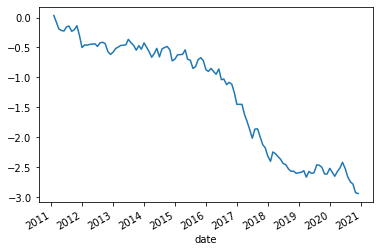

In [48]:
ic_series_cum.plot()

In [168]:
df_backtest = df_backtest.drop(columns = ['PE_TTM_resid'])

## Hiearachical Backtesting

In [124]:
NUM_GROUPS = 5
GROUP_NAMES = [f"group{i}_weight" for i in range(1, NUM_GROUPS + 1)]

In [65]:
from functools import partial
assigned_group = df_backtest.groupby('pri_indus_code')['PE_TTM'].apply(partial(pd.qcut, q=5, labels=range(5)))

In [66]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -1.172057 -0.600686 -0.605484 -1.423816  5.335556e+10   
           000002.XSHE -0.961356 -0.918099 -1.258194 -1.155533  7.937809e+10   
           000005.XSHE -1.969375  1.148736  1.506626  0.000946  3.200168e+09   
           000006.XSHE -0.988603 -1.017516  1.506626 -0.995730  5.409109e+09   
           000009.XSHE  0.325730  0.389740 -1.223694  1.511639  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688600.XSHG  1.220266  0.875626  1.228345  1.283916  2.733000e+09   
           688777.XSHG  1.220266  0.875626  1.228345  1.283916  6.092000e+10   
           688788.XSHG  1.220266  0.875626  1.228345  1.283916  1.728500e+10   
           688981.XSHG  1.220266  0.875626  1.228345  1.283916  4.562330e+11   
           689009.XSHG  1.220266  0.875626  1.228345  1.283916  5.023700e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688600.XSHG   20.49   20.50             16.86           -0.177561   
           688777.XSHG  122.00  124.00             99.58           -0.196935   
           688788.XSHG  223.00  228.84            134.49           -0.412297   
           688981.XSHG   58.88   59.25             57.00           -0.037975   
           689009.XSHG   72.60   71.35             82.00            0.149264   

                       secon_indus_code pri_indus_code  PE_TTM_resid  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J     -0.543802   
           000002.XSHE              K70              K     -0.373062   
           000005.XSHE              N77              N     -2.508548   
           000006.XSHE              K70              K     -0.447781   
           000009.XSHE              S90              S     -0.136127   
...                                 ...            ...           ...   
2020-11-30 688600.XSHG              C40              C      1.048560   
           688777.XSHG              I65              I      0.826291   
           688788.XSHG              C39              C      1.049692   
           688981.XSHG              C39              C      1.083826   
           689009.XSHG              C39              C      1.052255   

                        index_weight  
date       stock                      
2011-01-31 000001.XSHE      0.000557  
           000002.XSHE      0.000557  
           000005.XSHE      0.000557  
           000006.XSHE      0.000557  
           000009.XSHE      0.000557  
...                              ...  
2020-11-30 688600.XSHG      0.000259  
           688777.XSHG      0.000259  
           688788.XSHG      0.000259  
           688981.XSHG      0.000259  
           689009.XSHG      0.000259  

[299212 rows x 13 columns]

In [67]:
df_backtest[df_backtest.index.get_level_values(0) == '2011-01-31'].groupby('pri_indus_code')['PE_TTM'].count()

pri_indus_code
A      28
B      54
C    1038
D      78
E      45
F     107
G      67
H       6
I     107
J      60
K      94
L      32
M       7
N      25
P       3
Q      10
R      22
S      12
Name: PE_TTM, dtype: int64

In [68]:
#Here for simplicity we assume that index weight is a uniform portfolio over all stocks, to be modified later
df_backtest['index_weight'] = df_backtest.groupby(level=0).apply(lambda df: pd.Series([1/df.shape[0]] * df.shape[0])).values

In [75]:
#merge the industry weights of the index onto the backtesting dataframe
def set_index_indus_weight(df):
    index_indus_weight = df.groupby('pri_indus_code')['index_weight'].sum().rename('index_indus_weight')
    df = df.merge(index_indus_weight, how='left', left_on='pri_indus_code', right_index=True)
    return df
#'index_indus_weight' = this stock's industry weight in the benchmark index
if 'index_indus_weight' not in df_backtest.columns:
    df_backtest = applyParallel(df_backtest.groupby(level=0), set_index_indus_weight)

In [76]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -1.172057 -0.600686 -0.605484 -1.423816  5.335556e+10   
           000002.XSHE -0.961356 -0.918099 -1.258194 -1.155533  7.937809e+10   
           000005.XSHE -1.969375  1.148736  1.506626  0.000946  3.200168e+09   
           000006.XSHE -0.988603 -1.017516  1.506626 -0.995730  5.409109e+09   
           000009.XSHE  0.325730  0.389740 -1.223694  1.511639  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688600.XSHG  1.220266  0.875626  1.228345  1.283916  2.733000e+09   
           688777.XSHG  1.220266  0.875626  1.228345  1.283916  6.092000e+10   
           688788.XSHG  1.220266  0.875626  1.228345  1.283916  1.728500e+10   
           688981.XSHG  1.220266  0.875626  1.228345  1.283916  4.562330e+11   
           689009.XSHG  1.220266  0.875626  1.228345  1.283916  5.023700e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688600.XSHG   20.49   20.50             16.86           -0.177561   
           688777.XSHG  122.00  124.00             99.58           -0.196935   
           688788.XSHG  223.00  228.84            134.49           -0.412297   
           688981.XSHG   58.88   59.25             57.00           -0.037975   
           689009.XSHG   72.60   71.35             82.00            0.149264   

                       secon_indus_code pri_indus_code  PE_TTM_resid  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J     -0.543802   
           000002.XSHE              K70              K     -0.373062   
           000005.XSHE              N77              N     -2.508548   
           000006.XSHE              K70              K     -0.447781   
           000009.XSHE              S90              S     -0.136127   
...                                 ...            ...           ...   
2020-11-30 688600.XSHG              C40              C      1.048560   
           688777.XSHG              I65              I      0.826291   
           688788.XSHG              C39              C      1.049692   
           688981.XSHG              C39              C      1.083826   
           689009.XSHG              C39              C      1.052255   

                        index_weight  index_indus_weight  
date       stock                                          
2011-01-31 000001.XSHE      0.000557            0.033426  
           000002.XSHE      0.000557            0.052368  
           000005.XSHE      0.000557            0.013928  
           000006.XSHE      0.000557            0.052368  
           000009.XSHE      0.000557            0.006685  
...                              ...                 ...  
2020-11-30 688600.XSHG      0.000259            0.639170  
           688777.XSHG      0.000259            0.082490  
           688788.XSHG      0.000259            0.639170  
           688981.XSHG      0.000259            0.639170  
           689009.XSHG      0.000259            0.639170  

[299212 rows x 14 columns]

In [125]:
import numpy as np
# hiearchical backtesting is pretty hard to implement using purely vectorization/parrallelization, and I have to use for loop at least once.
def get_group_weight_by_industry(num_stocks, num_groups) -> np.array:
    """
    precondition: the stocks need to be sorted by factor exposure
    @num_stocks: the number of stocks in this industry
    @num_groups: the number of portfolio groups to be constructed
    
    returns: an intermediary (num_stocks x num_groups) weight matrix specifying the weight of 
             each stock in each group. Here weights within each group(column sum) adds up to 1.
             This is not the final weight matrix because there are many industries(so that weights within 
             each group should actually be smaller than one) but the returned
             weight matrix represents only one industry. 
    
    if you want to understand the algorithm deeper, print some intermediary outputs
    """
    num_rows = min(num_groups, num_stocks)
    num_cols = max(num_groups, num_stocks)
    weight_mat = np.zeros((num_rows, num_cols))
    remaining = 0
    j = 0
    row_budget = num_cols
    col_budget = num_rows
    for i in range(num_rows):
        # print(f"i = {i}")
        start = col_budget - remaining
        # print(f"start = {start}")
        weight_mat[i, j] = start
        offset = (row_budget - start) // col_budget
        # print(f"offset = {offset}")
        weight_mat[i, j + 1: j + 1 + offset] = col_budget
        remaining = row_budget - offset * col_budget - start
        j = j + 1 + offset
        if j < num_cols:
            weight_mat[i, j] = remaining
        
    weight_mat = weight_mat if num_groups > num_stocks else weight_mat.transpose()
    weight_mat_normalized = weight_mat / weight_mat.sum(axis=0)
    return weight_mat_normalized

def get_weight_df_by_industry(df: pd.DataFrame) -> pd.DataFrame:
    """get the weight dataframe for each industry"""
    #sort by the factor exposure
    df = df.sort_values(by='PE_TTM') 
    stock_names = df.index.get_level_values(1)
    #get weight matrix first
    weight_mat = get_group_weight_by_industry(stock_names.shape[0], NUM_GROUPS)
    df[GROUP_NAMES] = weight_mat
    return df

In [152]:
def get_group_weight_by_date(df_backtest_sub):
    #get the intermediary weights in each group on each rebalancing date
    df_backtest_sub = df_backtest_sub.groupby('pri_indus_code').apply(get_weight_df_by_industry).droplevel(0).sort_index(level=1)
    """
    we need to make the group portfolio industry-neutral with the index. That is, industry weights should be the same in both
    the group portfolio and the index. 
    """
    #multiply each stock's intermediary weight by its industry weight. since the intermediary weight within each group within each industry adds up to 1(as explained in the previous function),
    #after this operation the final stock weight within each group should add up to 1.
    df_backtest_sub[GROUP_NAMES] = np.multiply(df_backtest_sub[GROUP_NAMES].values, df_backtest_sub['index_indus_weight'].values[:, np.newaxis])
    return df_backtest_sub

In [146]:
df_backtest = df_backtest.groupby(level=0).apply(get_group_weight_by_date)

In [147]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -1.172057 -0.600686 -0.605484 -1.423816  5.335556e+10   
           000002.XSHE -0.961356 -0.918099 -1.258194 -1.155533  7.937809e+10   
           000005.XSHE -1.969375  1.148736  1.506626  0.000946  3.200168e+09   
           000006.XSHE -0.988603 -1.017516  1.506626 -0.995730  5.409109e+09   
           000009.XSHE  0.325730  0.389740 -1.223694  1.511639  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688600.XSHG  1.220266  0.875626  1.228345  1.283916  2.733000e+09   
           688777.XSHG  1.220266  0.875626  1.228345  1.283916  6.092000e+10   
           688788.XSHG  1.220266  0.875626  1.228345  1.283916  1.728500e+10   
           688981.XSHG  1.220266  0.875626  1.228345  1.283916  4.562330e+11   
           689009.XSHG  1.220266  0.875626  1.228345  1.283916  5.023700e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688600.XSHG   20.49   20.50             16.86           -0.177561   
           688777.XSHG  122.00  124.00             99.58           -0.196935   
           688788.XSHG  223.00  228.84            134.49           -0.412297   
           688981.XSHG   58.88   59.25             57.00           -0.037975   
           689009.XSHG   72.60   71.35             82.00            0.149264   

                       secon_indus_code pri_indus_code  PE_TTM_resid  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J     -0.543802   
           000002.XSHE              K70              K     -0.373062   
           000005.XSHE              N77              N     -2.508548   
           000006.XSHE              K70              K     -0.447781   
           000009.XSHE              S90              S     -0.136127   
...                                 ...            ...           ...   
2020-11-30 688600.XSHG              C40              C      1.048560   
           688777.XSHG              I65              I      0.826291   
           688788.XSHG              C39              C      1.049692   
           688981.XSHG              C39              C      1.083826   
           689009.XSHG              C39              C      1.052255   

                        index_weight  index_indus_weight  group1_weight  \
date       stock                                                          
2011-01-31 000001.XSHE      0.000557            0.033426       0.002786   
           000002.XSHE      0.000557            0.052368       0.000000   
           000005.XSHE      0.000557            0.013928       0.002786   
           000006.XSHE      0.000557            0.052368       0.000000   
           000009.XSHE      0.000557            0.006685       0.000000   
...                              ...                 ...            ...   
2020-11-30 688600.XSHG      0.000259            0.639170       0.000000   
           688777.XSHG      0.000259            0.082490       0.000000   
           688788.XSHG      0.000259            0.639170       0.000000   
           688981.XSHG      0.000259            0.639170       0.000000   
           689009.XSHG      0.000259            0.639170       0.000000   

                        group2_

In [148]:
df_backtest.groupby(level=0)[GROUP_NAMES].sum() #looks good

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.0,1.0,1.0,1.0,1.0
2011-02-28,1.0,1.0,1.0,1.0,1.0
2011-03-31,1.0,1.0,1.0,1.0,1.0
2011-04-29,1.0,1.0,1.0,1.0,1.0
2011-05-31,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
2020-07-31,1.0,1.0,1.0,1.0,1.0
2020-08-31,1.0,1.0,1.0,1.0,1.0
2020-09-30,1.0,1.0,1.0,1.0,1.0


In [149]:
def get_group_returns_by_date(df_backtest_sub):
    group_returns = df_backtest_sub[GROUP_NAMES].values.transpose() @ df_backtest_sub['next_period_return'].values
    group_returns = pd.Series(group_returns, index=GROUP_NAMES)
    return group_returns

group_returns_by_date = df_backtest.groupby(level=0).apply(get_group_returns_by_date)
group_returns_by_date

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,0.084514,0.069750,0.078116,0.088162,0.087878
2011-02-28,0.013354,-0.014211,-0.029735,-0.045759,-0.008339
2011-03-31,-0.053097,-0.085688,-0.096393,-0.097499,-0.081499
2011-04-29,-0.112998,-0.133315,-0.140138,-0.164378,-0.114640
2011-05-31,0.003155,-0.008442,-0.008615,-0.008722,0.006521
...,...,...,...,...,...
2020-07-31,0.047643,0.048356,0.032993,0.017337,0.022115
2020-08-31,-0.058016,-0.062266,-0.064032,-0.075034,-0.075128
2020-09-30,0.026314,0.041984,0.028093,0.024074,0.047781


In [150]:
group_cum_returns= (group_returns_by_date + 1).cumprod(axis=0)
group_cum_returns

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.084514,1.069750,1.078116,1.088162,1.087878
2011-02-28,1.098997,1.054547,1.046057,1.038369,1.078806
2011-03-31,1.040643,0.964186,0.945225,0.937129,0.990885
2011-04-29,0.923053,0.835645,0.812763,0.783086,0.877290
2011-05-31,0.925965,0.828591,0.805761,0.776256,0.883011
...,...,...,...,...,...
2020-07-31,1.245886,0.761703,0.592897,0.495341,1.600523
2020-08-31,1.173605,0.714274,0.554933,0.458173,1.480279
2020-09-30,1.204488,0.744262,0.570523,0.469203,1.551008


<AxesSubplot:xlabel='date'>

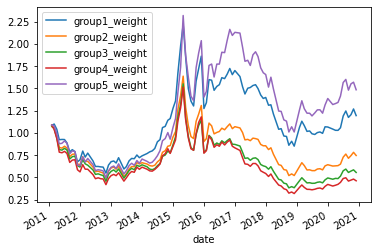

In [151]:
group_cum_returns.plot()

## Factor Combination

In [153]:
COMBINE_FACTORS = ['PE_TTM', 'PS_TTM']

In [163]:
def get_ic_series(factor, df_backtest=df_backtest):
    def wls_factor_resid(df):
        import statsmodels.formula.api as smf
        wls_result = smf.wls(formula = f"{factor} ~ 0 + market_value + C(pri_indus_code)", 
                        data=df, weights = df['market_value'] ** 0.5).fit()
        return wls_result.resid
    if f'{factor}_resid' not in df_backtest.columns:
        factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
        factor_resids = factor_resids.rename(f'{factor}_resid')
        df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)
    def cross_sectional_ic(df):
        return df[['next_period_return', f'{factor}_resid']].corr(method='spearman').iloc[0, 1]
    ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)
    return ic_series

In [166]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -1.172057 -0.600686 -0.605484 -1.423816  5.335556e+10   
           000002.XSHE -0.961356 -0.918099 -1.258194 -1.155533  7.937809e+10   
           000005.XSHE -1.969375  1.148736  1.506626  0.000946  3.200168e+09   
           000006.XSHE -0.988603 -1.017516  1.506626 -0.995730  5.409109e+09   
           000009.XSHE  0.325730  0.389740 -1.223694  1.511639  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688600.XSHG  1.220266  0.875626  1.228345  1.283916  2.733000e+09   
           688777.XSHG  1.220266  0.875626  1.228345  1.283916  6.092000e+10   
           688788.XSHG  1.220266  0.875626  1.228345  1.283916  1.728500e+10   
           688981.XSHG  1.220266  0.875626  1.228345  1.283916  4.562330e+11   
           689009.XSHG  1.220266  0.875626  1.228345  1.283916  5.023700e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688600.XSHG   20.49   20.50             16.86           -0.177561   
           688777.XSHG  122.00  124.00             99.58           -0.196935   
           688788.XSHG  223.00  228.84            134.49           -0.412297   
           688981.XSHG   58.88   59.25             57.00           -0.037975   
           689009.XSHG   72.60   71.35             82.00            0.149264   

                       secon_indus_code pri_indus_code  PE_TTM_resid  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J     -0.543802   
           000002.XSHE              K70              K     -0.373062   
           000005.XSHE              N77              N     -2.508548   
           000006.XSHE              K70              K     -0.447781   
           000009.XSHE              S90              S     -0.136127   
...                                 ...            ...           ...   
2020-11-30 688600.XSHG              C40              C      1.048560   
           688777.XSHG              I65              I      0.826291   
           688788.XSHG              C39              C      1.049692   
           688981.XSHG              C39              C      1.083826   
           689009.XSHG              C39              C      1.052255   

                        index_weight  index_indus_weight  group1_weight  \
date       stock                                                          
2011-01-31 000001.XSHE      0.000557            0.033426       0.002786   
           000002.XSHE      0.000557            0.052368       0.000000   
           000005.XSHE      0.000557            0.013928       0.002786   
           000006.XSHE      0.000557            0.052368       0.000000   
           000009.XSHE      0.000557            0.006685       0.000000   
...                              ...                 ...            ...   
2020-11-30 688600.XSHG      0.000259            0.639170       0.000000   
           688777.XSHG      0.000259            0.082490       0.000000   
           688788.XSHG      0.000259            0.639170       0.000000   
           688981.XSHG      0.000259            0.639170       0.000000   
           689009.XSHG      0.000259            0.639170       0.000000   

                        group2_

In [170]:
#The multiprocessing takes forever, not sure why
#had to use for loop for now. Look into this later

# with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool: 
#     ic_series_results = pool.map( get_ic_series, COMBINE_FACTORS)
ic_series_results = [get_ic_series(factor).rename(factor) for factor in COMBINE_FACTORS] #around 8 seconds
df_ic_series = pd.concat(ic_series_results, axis=1)

In [171]:
df_ic_series

,PE_TTM,PS_TTM
date,,
2011-01-31,0.033626,-0.112127
2011-02-28,-0.102044,-0.283314
2011-03-31,-0.120976,-0.186137
2011-04-29,-0.026443,-0.075327
2011-05-31,-0.009745,0.027687
...,...,...
2020-07-31,-0.143478,-0.086133
2020-08-31,-0.080358,-0.054620
2020-09-30,-0.036634,-0.001792


In [173]:
hist_periods = 12
df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,-0.006092,0.012690
2020-08-31,-0.023756,-0.002071
2020-09-30,-0.026175,-0.011461


In [ ]:
#leave the computation for later
# A = np.arange(6).reshape(2,3) # 2 x 3, N = 2, T = 3
# S = pd.DataFrame(A).T.cov() #2 x 2
# np.expand_dims(A, 0)

array([[[0, 1, 2],
        [3, 4, 5]]])

In [174]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()
df_ic_cov_mat_series

PE_TTM    PS_TTM
date                                 
2011-01-31 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-02-28 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-03-31 PE_TTM       NaN       NaN
...                     ...       ...
2020-09-30 PS_TTM  0.007342  0.007717
2020-10-30 PE_TTM  0.009327  0.008753
           PS_TTM  0.008753  0.009253
2020-11-30 PE_TTM  0.008809  0.008323
           PS_TTM  0.008323  0.008990

[224 rows x 2 columns]

#### maximize the ICIR values on a single rebalancing date

In [175]:
w = np.array([0.5, 0.5])

In [176]:
pd.date_range(START_DATE, END_DATE)

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3653, freq='D')

In [177]:
df_ic_hist_mean = df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

In [178]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()

In [179]:
df_ic = df_ic_series[df_ic_series.index == '2020-09-30']
df_ic

,PE_TTM,PS_TTM
date,,
2020-09-30,-0.036634,-0.001792


In [180]:
df_ic_cov_mat = df_ic_cov_mat_series[df_ic_cov_mat_series.index.get_level_values(0) == '2020-09-30']
df_ic_cov_mat

PE_TTM    PS_TTM
date                                 
2020-09-30 PE_TTM  0.008169  0.007342
           PS_TTM  0.007342  0.007717

In [181]:
w @ df_ic_cov_mat.values @ w.transpose()

0.007642537565017666

In [182]:
w.transpose() @ df_ic.values.flatten()

-0.01921298231138965

In [183]:
def get_ic_ir(factor_weights):
    ic_mean = factor_weights.transpose() @ df_ic.values.flatten()
    ic_var = factor_weights @ df_ic_cov_mat.values @ factor_weights.transpose()
    return ic_mean / (ic_var ** 0.5)

In [184]:
df_ic_cov_mat.shape

(2, 2)

In [185]:
num_factors = len(COMBINE_FACTORS)
opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
opt_factor_weight = opt_result.x

In [186]:
opt_factor_weight

array([0., 1.])

#### optimal factor weight on all rebalancing dates

In [ ]:
df_ic_series.rolling(12).apply(lambda df: df.mean() )

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,-0.006092,0.010371
2020-08-31,-0.023756,-0.001592
2020-09-30,-0.026175,-0.017854


In [190]:
df_ic_series.index[hist_periods:]

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-30', '2012-05-31',
               '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28',
               '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-29', '2013-05-31', '2013-06-28',
               '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31',
               '2013-11-29', '2013-12-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31',
               '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28',
               '2014-12-31', '2015-01-30', '2015-02-27', '2015-03-31',
               '2015-04-30', '2015-05-29', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30',
               '2015-12-31', '2016-01-29', '2016-02-29', '2016-03-31',
               '2016-04-29', '2016-05-31', '2016-06-30', '2016-07-29',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
      

In [188]:
def get_opt_factor_weight_by_date(date): 
    df_ic = df_ic_series[df_ic_series.index == date]
    df_pred_ic = df_ic.rolling(hist_periods).mean()
    print('11111')
    print(df_pred_ic)
    df_pred_ic_cov_mat = df_ic.rolling(hist_periods).cov()
    print('a')
    def get_ic_ir(factor_weights):
        combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
        combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
        combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
        return combined_ir
    print('b')
    opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
    print('c')
    opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
    print('d')
    return opt_result.x

In [197]:
valid_dates = df_ic_series.index[hist_periods:]
results = [get_opt_factor_weight_by_date(date) for date in valid_dates]

11111
            PE_TTM  PS_TTM
date                      
2012-01-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-02-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-03-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-05-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-06-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-07-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-08-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-09-28     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-10-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-11-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date             

In [200]:
results #TBD: not sure why the optimization is not working, debug

[array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),


In [ ]:
#we cannot use pandas.rolling.apply(func) because rolling.apply is different from groupby.apply -- it cannot take a dataframe as the parameter


# num_factors = len(COMBINE_FACTORS)
# def get_opt_factor_weight_by_date(ic_series: pd.Series): 
#     df = df_ic_series.loc[ic_series.index, :]
#     df_pred_ic = df.mean()
#     print('11111')
#     print(df_pred_ic)
#     df_pred_ic_cov_mat = df.cov()
#     print('a')
#     def get_ic_ir(factor_weights):
#         combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
#         combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
#         combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
#         return combined_ir
#     print('b')
#     opt_result = scipy.optimize.minimize(
#                 lambda w: -get_ic_ir(w),
#                 np.array([1 / num_factors] * num_factors),
#                 bounds=[(0, 1) for i in range(num_factors)],
#                 constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
#             )
#     print('c')
#     date = df.index[0]
#     opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
#     print('d')
#     return opt_result.x

# df_ic_series.rolling(12).apply(get_opt_factor_weight_by_date)

### Missing Value Analysis(Done by Hankle and Jason)

In [ ]:
# Calculate percentage of data missing for each stock, 
# record all stocks that have more than 50% data missing
missing = backtest_price_data.isnull().sum().reset_index().rename(columns = {0:'missNum'}).sort_values('missNum')
missing['missRate'] = missing['missNum']/backtest_price_data.shape[0]
missing = missing[missing.missRate > 0.5].sort_values(by = 'missRate', ascending=False)
missing

NameError: name 'backtest_price_data' is not defined

In [ ]:
# Drop entries of stock with more than 50% data missing
removed_code = missing['index'].to_list()
backtest_codes = list(set(backtest_price_data.columns) - set(removed_code))

# FIXME: dropping stock data at the end of 10 yrs testing period is a form of look ahead bias
backtest_price_data = backtest_price_data[backtest_codes] 

In [ ]:
# Store processed price data to HDF files
price_data.to_hdf('full price data.h5',key='price')
backtest_price_data.to_hdf('10-year non-ST price data.h5', key='price')

#### Download factor data

In [ ]:
# Fill in factors intended to download, startdate, and enddate
# to bulk download. Downloaded file is saved to './data/factor'.
# Refer to Ricequant doc for all available factors:
# https://www.ricequant.com/welcome/rqdata 


factor_list = ['OBOS']
startdate = '20201001'
enddate = '20211001'

for factor in []:
    dl.download_factor_data(price_data.columns, factor, '20201001', '20211001') 

#### Missing value analysis of factor data

In [ ]:
dl.load_factor_data('OBOS')

OBOS
order_book_id date            
000001.XSHE   2021-08-31  -4.0
              2021-09-01  -4.0
              2021-09-02  -2.0
              2021-09-03  -2.0
              2021-09-06   0.0
              2021-09-07   0.0
              2021-09-08   0.0
              2021-09-09   0.0
              2021-09-10   2.0
              2021-09-13   2.0
              2021-09-14   0.0
              2021-09-15   0.0
              2021-09-16  -2.0
              2021-09-17  -2.0
              2021-09-22  -4.0
              2021-09-23  -6.0
              2021-09-24  -6.0
              2021-09-27  -4.0
              2021-09-28  -4.0
              2021-09-29  -2.0
              2021-09-30  -2.0